In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [27]:
data = pd.read_csv(r"C:\Users\Namrata Vasant Borse\Downloads\daily-website-visitors.csv")
data = data.dropna()

In [28]:
data.head()

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2167 entries, 0 to 2166
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Row                2167 non-null   int64 
 1   Day                2167 non-null   object
 2   Day.Of.Week        2167 non-null   int64 
 3   Date               2167 non-null   object
 4   Page.Loads         2167 non-null   object
 5   Unique.Visits      2167 non-null   object
 6   First.Time.Visits  2167 non-null   object
 7   Returning.Visits   2167 non-null   object
dtypes: int64(2), object(6)
memory usage: 135.6+ KB


In [30]:
data.describe()

,Row,Day.Of.Week
count,2167.000000,2167.000000
mean,1084.000000,3.997231
std,625.703338,2.000229
min,1.000000,1.000000
25%,542.500000,2.000000
50%,1084.000000,4.000000
75%,1625.500000,6.000000
max,2167.000000,7.000000


In [31]:
data.isnull().sum()

Row                  0
Day                  0
Day.Of.Week          0
Date                 0
Page.Loads           0
Unique.Visits        0
First.Time.Visits    0
Returning.Visits     0
dtype: int64

In [32]:
data.shape

(2167, 8)

In [33]:
#df['Page.Loads'] = df['Page.Loads'].str.replace(',', '').astype(float)
# Convert numerical columns to integers
num_cols = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']
for col in num_cols:
    data[col] = data[col].astype(str).str.replace(',', '').astype(float)

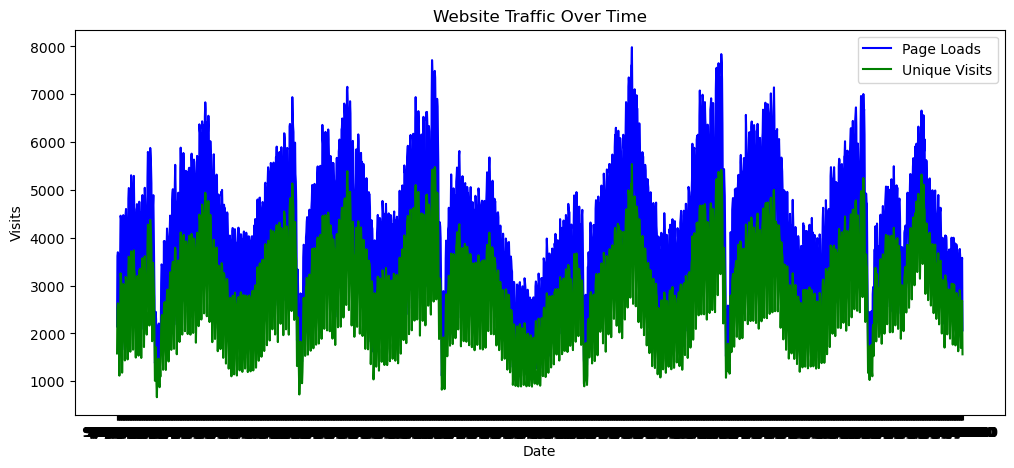

In [34]:
# Time-Series Plot
plt.figure(figsize=(12, 5))
plt.plot(data['Date'], data['Page.Loads'], label='Page Loads', color='blue')
plt.plot(data['Date'], data['Unique.Visits'], label='Unique Visits', color='green')
plt.xlabel('Date')
plt.ylabel('Visits')
plt.title('Website Traffic Over Time')
plt.legend()
plt.show()

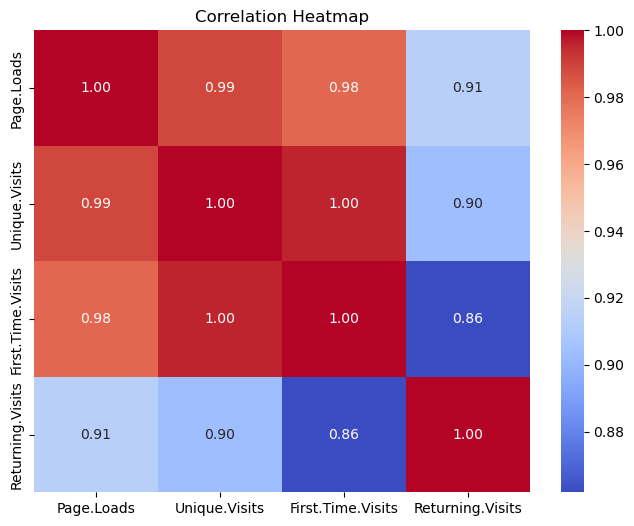

In [38]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data[['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']].corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


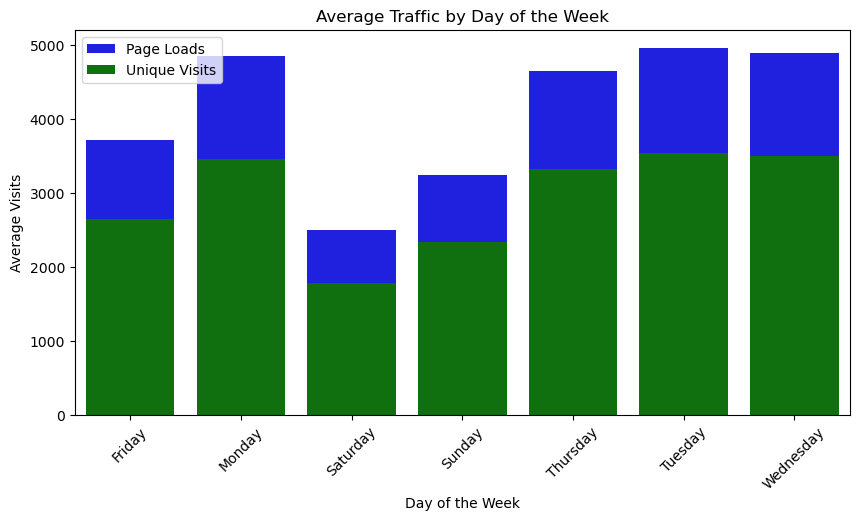

In [42]:
# Day of Week Analysis
if not pd.api.types.is_datetime64_any_dtype(data['Date']):
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

data = data.dropna(subset=['Date'])  # Ensure no NaT values exist
data['Day'] = data['Date'].dt.day_name()
avg_visits_per_day = data.groupby('Day')[['Page.Loads', 'Unique.Visits']].mean()

plt.figure(figsize=(10, 5))
sns.barplot(x=avg_visits_per_day.index, y=avg_visits_per_day['Page.Loads'], color='blue', label='Page Loads')
sns.barplot(x=avg_visits_per_day.index, y=avg_visits_per_day['Unique.Visits'], color='green', label='Unique Visits')
plt.title('Average Traffic by Day of the Week')
plt.ylabel('Average Visits')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['Page.Loads']])


In [10]:
# Create Sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


In [11]:
# Define Sequence Length (Past 30 Days)
SEQ_LENGTH = 30


In [12]:
# Create Train/Test Data
train_size = int(len(data_scaled) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]


In [13]:
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

In [14]:
# Reshape Data for LSTM (Samples, Timesteps, Features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [28]:
# Build LSTM Model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

In [16]:
# Compile Model
model.compile(optimizer='adam', loss='mse')

In [17]:
# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0606 - val_loss: 0.0197
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0292 - val_loss: 0.0235
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0292 - val_loss: 0.0197
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0277 - val_loss: 0.0211
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0269 - val_loss: 0.0195
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0269 - val_loss: 0.0182
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0272 - val_loss: 0.0234
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0244 - val_loss: 0.0151
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0207 - val_loss: 0.0128
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0176 - val_loss: 0.0105
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0146 - val_loss: 0.0085
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━

In [18]:
# Predict on Test Data
y_pred = model.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [19]:
# Inverse Scale Predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)


In [20]:
# Evaluate Model
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)


In [21]:
print(f"🔹 LSTM Model Performance:")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")


🔹 LSTM Model Performance:
MAE: 338.43, MSE: 200064.91, RMSE: 447.29


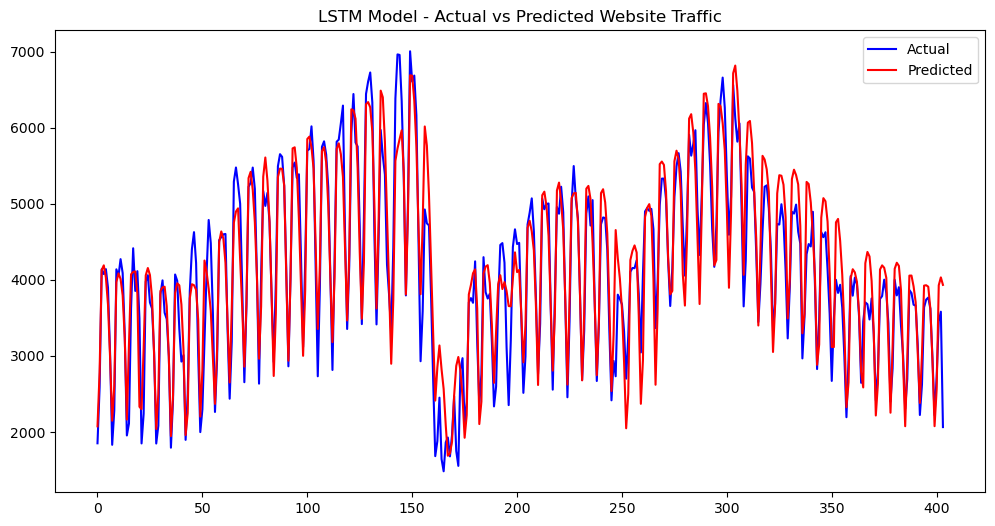

In [22]:
# Plot Predictions vs Actual
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual", color='blue')
plt.plot(y_pred_inv, label="Predicted", color='red')
plt.legend()
plt.title("LSTM Model - Actual vs Predicted Website Traffic")
plt.show()


In [23]:
# Forecast Next 30 Days
last_sequence = data_scaled[-SEQ_LENGTH:]
future_preds = []


In [24]:
for _ in range(30):
    pred = model.predict(last_sequence.reshape(1, SEQ_LENGTH, 1))
    future_preds.append(pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

In [25]:
# Inverse Transform Future Forecast
future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))


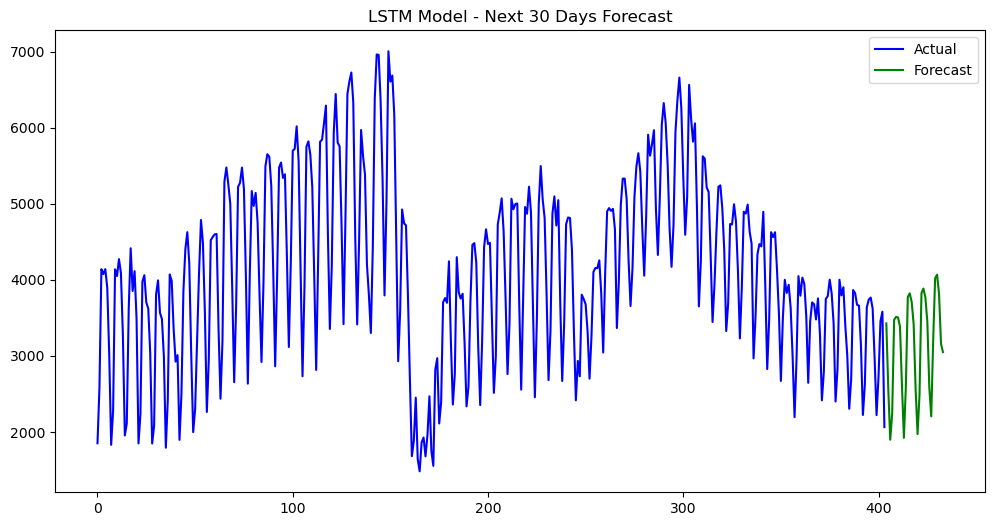

In [26]:
# Plot Forecast
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_inv)), y_test_inv, label="Actual", color='blue')
plt.plot(range(len(y_test_inv), len(y_test_inv) + 30), future_preds_inv, label="Forecast", color='green')
plt.legend()
plt.title("LSTM Model - Next 30 Days Forecast")
plt.show()
